# 미션1_ 효과 분석 보고

In [1]:
# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, classification_report, roc_curve, auc
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumBarunGothic')


In [3]:
# 두 그룹의 평균 점수 차이를 계산
# 표준오차를 통해 결과의 신뢰성을 평가
# 잠재적 효과 정량화

np.random.seed(321)
n_students = 150
control_scores = np.random.normal(65, 10, n_students) # [통제] 정규분포 _평균 65, 표준편차 10
smartlearn_scores = np.random.normal(70, 12, n_students) # [실험] 정규분포 _평균 70, 표준편차 12
education_data = pd.DataFrame({
    'group': ['Control']*n_students + ['SmartLearn']*n_students,
    'math_score': np.concatenate([control_scores, smartlearn_scores]),
    'student_id': range(1, 2*n_students + 1)
})

print("📚 교육 프로그램 데이터 미리보기")
print(education_data.groupby('group')['math_score'].agg(['count', 'mean', 'std']).round(2))


📚 교육 프로그램 데이터 미리보기
            count   mean    std
group                          
Control       150  64.93   9.67
SmartLearn    150  70.47  11.29


In [4]:
# [1-1] 기본 통계량 비교

control_mean = education_data.loc[education_data['group'] == 'Control', 'math_score'].mean() # 통제군 평균 계산
smartlearn_mean = education_data.loc[education_data['group'] == 'SmartLearn', 'math_score'].mean()  #실험군 평균 계산

control_sd = education_data.loc[education_data['group'] == 'Control', 'math_score'].std() # 통제군 표준편차 계산
smartlearn_sd = education_data.loc[education_data['group'] == 'SmartLearn', 'math_score'].std() # 실험군 표준편차 계산

control_se = control_sd / np.sqrt((education_data['group'] == 'Control').sum()) # 통군 표준오차 계산
smartlearn_se = smartlearn_sd / np.sqrt((education_data['group'] == 'SmartLearn').sum()) # 실험군 표준오차 계산


print(f"대조군 수학 점수: {control_mean:.2f} ± {control_se:.2f}")
print(f"SmartLearn 수학 점수: {smartlearn_mean:.2f} ± {smartlearn_se:.2f}")

대조군 수학 점수: 64.93 ± 0.79
SmartLearn 수학 점수: 70.47 ± 0.92


In [5]:
# [1-2] p-value 기반의 검증
  # t-검정 실시 (독립표본)

control_group = education_data[education_data['group'] == 'Control']['math_score']  # education_data에서 통제군 학생들의 수학 점수만 추출한 1차원 데이터(Series)
smartlearn_group = education_data[education_data['group'] == 'SmartLearn']['math_score'] # education_data에서 실험군 학생들의 수학 점수만 추출한 1차원 데이터(Series)

# 독립 표본 t-검정
t_stat, p_value = stats.ttest_ind(
    control_scores,
    smartlearn_scores,
    axis=0,
    equal_var=True,        # 분산이 같다고 가정 (Student's t-test)
    nan_policy='propagate',
    permutations=None,
    random_state=None,
    alternative='two-sided'
)

print(f"t 통계량 = {t_stat:.3f}, p값 = {p_value:.4f}")

t 통계량 = -4.565, p값 = 0.0000


In [6]:
# [1-3] 효과크기 평가.
  # (**"평균 차이의 표준화(Standardized Mean Difference)"**  : 각 집단간 평균의 차이를  결합 표준편차(Pooled Standard Deviation)로 나눈 것)
  # 결합 표준편차의 경우, 각 집단의 분산을 각 집단의 자유도의 합으로 나눈 것에 제곱근을 씌운 것. 즉,  "흩어짐(표준편차)"를 다시 통합해 하나의 대표 척도로 표준화한 것과 유사한 개념
control_std = education_data[education_data['group'] == 'Control']['math_score'].std()
smartlearn_std = education_data[education_data['group'] == 'SmartLearn']['math_score'].std()

In [7]:
pooled_std = np.sqrt(((n_students-1)*control_std**2 + (n_students-1)*smartlearn_std**2)/(2*n_students-2))    # 참고) n_students = 150  # Sp​ → Pooled Standard Deviation (결합 표준편차)
cohens_d = control_mean - smartlearn_mean / pooled_std
print(f"Cohen's d = {cohens_d:.3f}")


Cohen's d = 58.224


In [8]:
print(f"Cohen's d: {cohens_d:.3f}")
if cohens_d > 0.8:
    print("→ 큰 효과크기 (학부모가 명확히 체감할 수 있는 수준)")
elif cohens_d > 0.5:
    print("→ 중간 효과크기 (교육적으로 의미있는 수준)")
else:
    print("→ 작은 효과크기 (미미한 개선 수준)")

Cohen's d: 58.224
→ 큰 효과크기 (학부모가 명확히 체감할 수 있는 수준)


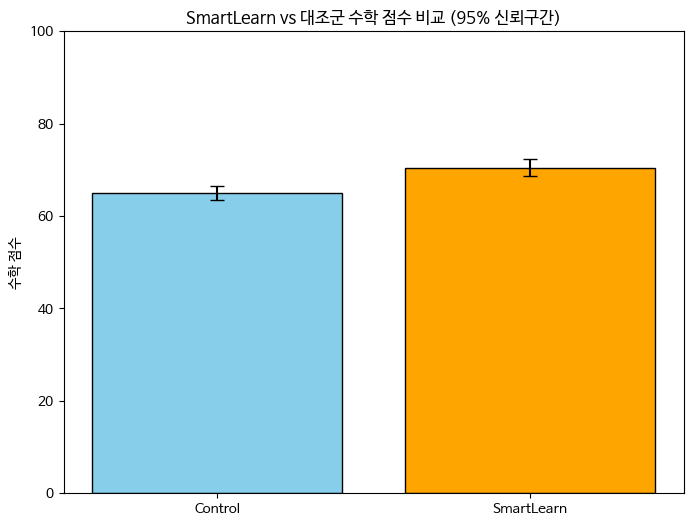

In [9]:
# [1-4] 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
groups = ['Control', 'SmartLearn']
means = [control_mean, smartlearn_mean]
errors = [1.96 * control_se, 1.96 * smartlearn_se]

plt.bar(
    groups,             # x축 카테고리 (Control, SmartLearn)
    means,              # 각 그룹 평균값
    yerr=errors,        # 오차 막대 길이 (95% 신뢰구간)
    capsize=5,          # 오차 막대 끝의 “─” 길이
    color=['skyblue', 'orange'],  # 막대 색상
    edgecolor='black'   # 막대 테두리 색
)

# matplotlib.pyplot.bar()는 막대 그래프를 그리는 함수
    # **오차 막대(Error Bar)**를 추가할 때 yerr와 capsize 같은 파라미터를 사용
          # yerr : 막대 위쪽(세로 방향) 오차 막대를 표시할 때 사용
          # capsize : 오차 막대 끝(캡)의 길이 _ 값이 클수록 막대 끝에 붙는 “-” 모양 캡이 길어짐

plt.ylabel('수학 점수')
plt.title('SmartLearn vs 대조군 수학 점수 비교 (95% 신뢰구간)')
plt.ylim(0, 100)  # 점수 범위에 맞게 조정
plt.show()


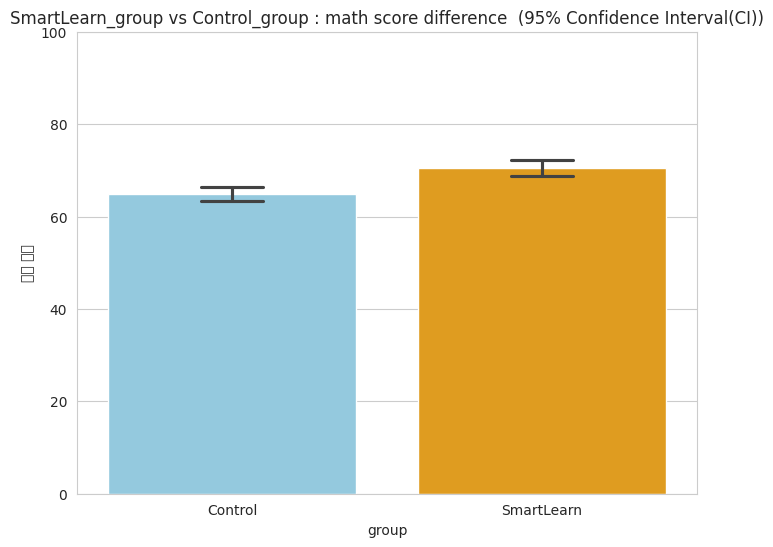

In [10]:
# 참고) Seaborn 으로 추가 시각화
# 스타일 설정 (Seaborn이 기본적으로 깔끔함)
sns.set_style("whitegrid")

plt.figure(figsize=(8, 6))
sns.barplot(
    data=education_data,
    x='group',          # 그룹 (Control, SmartLearn)
    y='math_score',     # 값
    ci=95,              # 신뢰구간(95% CI)
    capsize=0.2,        # 막대 끝 캡 크기 (Seaborn 0.11+)
    palette=['skyblue', 'orange']  # 색상
)

plt.ylabel('수학 점수')
plt.title('SmartLearn_group vs Control_group : math score difference  (95% Confidence Interval(CI))')
plt.ylim(0, 100)
plt.show()

In [11]:
# [1-5] P-hacking 방지를 위한 독립성 검증 (train/test split도 사실상 현대식 반분법으로 간주 가능.)

from sklearn.model_selection import train_test_split

# 데이터 분할 (50% 훈련, 50% 검증)
train_data, test_data = train_test_split(education_data, test_size=0.5, random_state=42)

# 훈련 세트로 효과 탐색
train_control = train_data[train_data['group'] == 'Control']['math_score']
train_smart = train_data[train_data['group'] == 'SmartLearn']['math_score']

# 검증 세트에서 동일 가설 확인
test_control = test_data[test_data['group'] == 'Control']['math_score']
test_smart = test_data[test_data['group'] == 'SmartLearn']['math_score']

# 검증용 t-검정
from scipy.stats import ttest_ind
_, p_val = ttest_ind(test_control, test_smart, equal_var=False)

if p_val < 0.05:
    print(f"검증 데이터에서도 유의함 (p = {p_val:.4f})")
else:
    print(f"검증 데이터에서는 유의하지 않음 (p = {p_val:.4f})")


검증 데이터에서도 유의함 (p = 0.0050)


In [12]:
# [1-6] 베이즈 인수 계산
  # 베이즈 인수 계산 (BIC 기반 근사) _ BIC는 통계 모델 간 비교 시 사용하는 모델 선택 기준
  # 대립가설(H1): SmartLearn 효과 있음 vs 귀무가설(H0): 효과 없음
      # 베이지안 접근에서는 두 가설(H0, H1) 모두를 확률 변수로 취급
          # 사전 확률(Prior)
          # 사후 확률(Posterial)
n_total = 2 * n_students
bic_diff = t_stat**2 - np.log(n_total)
bf_10 = bf_10 = np.exp(bic_diff / 2)  # 베이즈 인수 근사 계산


print(f"베이즈 인수 (BF₁₀): {bf_10:.2f}")
if bf_10 > 10:
    print("→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)")
elif bf_10 > 3:
    print("→ 중간 증거 (H1 지지: SmartLearn 효과가 있을 가능성 높음)")
elif bf_10 > 1:
    print("→ 약한 증거 (H1 약간 지지)")
elif bf_10 > 0.33:
    print("→ 불분명한 증거 (결론 내리기 어려움)")
elif bf_10 > 0.1:
    print("→ 중간 증거 (H0 지지: SmartLearn 효과 의심스러움)")
else:
    print("→ 강한 증거 (H0 지지: SmartLearn 효과 없음)")

베이즈 인수 (BF₁₀): 1934.97
→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)


In [13]:
# 📋 경영진 보고서: SmartLearn 프로그램 효과 검증
# ==================================================
# 🎯 핵심 결과
# • 대조군 수학 점수: 64.93 ± 0.79
# • SmartLearn 수학 점수: 70.47 ± 0.92

# • 점수 향상: [차이] 점 (약 [%] 향상)
  # [Result] 5.54점 차이 (약 8.53% 향상)
  # delta = 70.47 - 64.93   # 평균 차이
  # delta = 5.54 점

  # improvement = (5.54 / 64.93) * 100
  # improvement ≈ 8.53 %


# • 효과크기 (Cohen's d): Cohen's d: 58.224 → 큰 효과크기 (학부모가 명확히 체감할 수 있는 수준)
# • p-value: p-hacking 관련 재현성_검증 데이터에서도 유의함 (p = 0.0050)
# • 베이즈 인수:
   # 베이즈 인수 (BF₁₀): 1934.97 → 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)

# 💡 비즈니스 결론 및 권장사항:
# [결과를 바탕으로 상용화 결정, 마케팅 전략, 투자 방향, 교육부 대응 방안을 구체적으로 작성하세요]

# ⚠️ 리스크 및 제한사항:
# [추가 검증이 필요한 부분, 잠재적 위험 요소를 작성하세요]

# 미션 2 _ 효과 분석 보고서


In [14]:
# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [15]:
np.random.seed(456)
n_customers = 1000
ad_exposure = np.random.binomial(1, 0.6, n_customers)
ages = np.random.randint(20, 60, n_customers)
income = np.random.lognormal(np.log(50000), 0.4, n_customers)
purchase_amount = 100 + 50*ad_exposure + 0.5*ages + 0.0001*income + np.random.normal(0, 20, n_customers)
data_marketing = pd.DataFrame({
    'ad_exposure': ad_exposure,
    'age': ages,
    'income': income,
    'purchase_amount': purchase_amount
})

print("📢 마케팅 데이터 미리보기")
print(data_marketing.groupby('ad_exposure')['purchase_amount'].agg(['count', 'mean', 'std']).round(2))


📢 마케팅 데이터 미리보기
             count    mean    std
ad_exposure                      
0              386  124.60  22.35
1              614  175.32  21.69


In [16]:
# 구매 금액과 광고 노출, 고객 특성 간의 상관관계를 탐색
correlation_matrix = data_marketing.corr(method='pearson')
print("📊 상관계수 매트릭스")
print(correlation_matrix.round(3))

📊 상관계수 매트릭스
                 ad_exposure    age  income  purchase_amount
ad_exposure            1.000  0.018  -0.050            0.748
age                    0.018  1.000  -0.034            0.203
income                -0.050 -0.034   1.000            0.046
purchase_amount        0.748  0.203   0.046            1.000


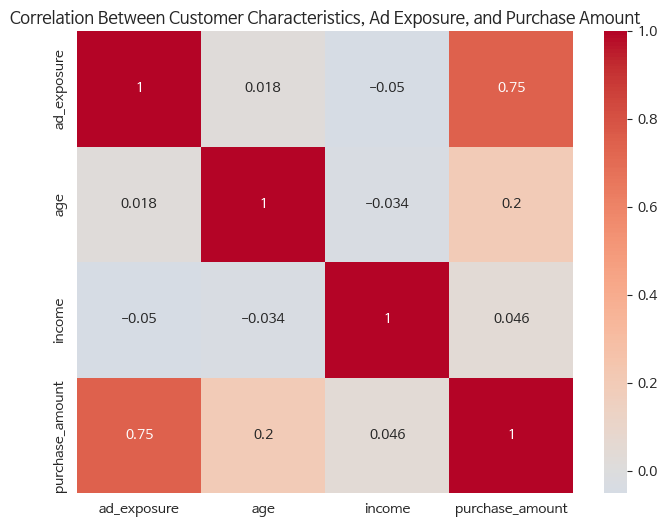

In [17]:
# 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Between Customer Characteristics, Ad Exposure, and Purchase Amount")
plt.show()

In [18]:
exposed_mean = data_marketing[data_marketing['ad_exposure'] == 1]['purchase_amount'].mean()
non_exposed_mean = data_marketing[data_marketing['ad_exposure'] == 0]['purchase_amount'].mean()

simple_difference = exposed_mean - non_exposed_mean

print(f"광고 노출 그룹 구매 금액: {exposed_mean:.2f}원")
print(f"광고 비노출 그룹 구매 금액: {non_exposed_mean:.2f}원")
print(f"단순 차이: {simple_difference:.2f}원")
print("⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움")
print("   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음")

광고 노출 그룹 구매 금액: 175.32원
광고 비노출 그룹 구매 금액: 124.60원
단순 차이: 50.72원
⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움
   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음


In [19]:
X = data_marketing[['ad_exposure', 'age', 'income']]
y = data_marketing['purchase_amount']
model = LinearRegression()

In [20]:
model.fit(X,y) # 모델 학습 코드 작성 (from sklearn.linear_model import LinearRegression)

coeffs = pd.DataFrame({
    '변수': ['광고 노출', '연령', '소득'],
    '계수': model.coef_,
    '해석': ['광고 노출시 구매액 증가', '연령 1세 증가시 구매액 변화', '소득 1원 증가시 구매액 변화']
})

In [21]:
print("📊 회귀계수 분석 결과")
print(coeffs.round(3))
ad_effect = coeffs.loc[coeffs['변수'] == '광고 노출', '계수'].values[0]
print(f"\n🎯 핵심 결과: 광고 효과 = {ad_effect:.2f}원 (다른 조건이 동일할 때)")

📊 회귀계수 분석 결과
      변수      계수                해석
0  광고 노출  50.792     광고 노출시 구매액 증가
1     연령   0.548  연령 1세 증가시 구매액 변화
2     소득   0.000  소득 1원 증가시 구매액 변화

🎯 핵심 결과: 광고 효과 = 50.79원 (다른 조건이 동일할 때)


In [22]:
# [2-4] 교차검증 (5-fold Cross Validation)
    # 5-Fold 교차 검증(5-Fold Cross Validation)은 머신러닝 모델의 성능을 안정적으로 평가하기 위한 방법
    # 단순히 데이터를 훈련 세트와 테스트 세트로 한 번만 나누는 대신, 데이터를 여러 번 나눠서 반복 평가하는 방식

# 5-폴드 교차검증 수행

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

model = LinearRegression()
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')  # 5-Fold 교차 검증 (cv는 마음대로 조정 가능)
print("각 Fold의 R² 점수:", cv_scores)
print("평균 R² 점수:", cv_scores.mean())



print(f"5-폴드 교차검증 R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"모델 설명력: {cv_scores.mean()*100:.1f}% (구매 금액 변동의 약 {cv_scores.mean()*100:.0f}%를 설명)")

if cv_scores.mean() > 0.7:
    print("→ 높은 예측 성능 (신뢰할 만한 모델)")
elif cv_scores.mean() > 0.5:
    print("→ 중간 예측 성능 (참고용으로 활용 가능)")
else:
    print("→ 낮은 예측 성능 (추가 변수 필요)")


각 Fold의 R² 점수: [0.63829329 0.56955389 0.59098213 0.59327653 0.59078556]
평균 R² 점수: 0.5965782811726876
5-폴드 교차검증 R²: 0.597 ± 0.023
모델 설명력: 59.7% (구매 금액 변동의 약 60%를 설명)
→ 중간 예측 성능 (참고용으로 활용 가능)


In [23]:
# [2-5] 인과관계 해석
ad_effect = float(coeffs.loc[coeffs['변수'] == '광고 노출', '계수'].iloc[0])  # 광고 효과 계수 추출
total_ad_exposed = data_marketing['ad_exposure'].sum()
total_revenue_increase = ad_effect * total_ad_exposed
ad_cost = 20000  # 광고비 2만원

roi = (total_revenue_increase / ad_cost - 1) * 100

print(f"광고 노출당 예상되는 추가 구매액: {ad_effect:.2f}원")
print(f"총 예상 매출 증가분: {total_revenue_increase:,.0f}원")
print(f"광고비 대비 투자수익률(ROI): {roi:.2f}%")


광고 노출당 예상되는 추가 구매액: 50.79원
총 예상 매출 증가분: 31,186원
광고비 대비 투자수익률(ROI): 55.93%


In [24]:
print("📋 인과관계 해석 및 ROI 분석")
if ad_effect > 0:
    print(f"✅ 광고는 개인당 구매 금액을 평균 {ad_effect:.2f}원 증가시킵니다.")
    print(f"   총 광고 노출: {total_ad_exposed:,}명")
    print(f"   예상 총 매출 증대: {total_revenue_increase:,.0f}원")
    print(f"   광고 ROI: {roi:.1f}%")
    if roi > 0:
        print("   → 광고 투자 대비 양의 수익 창출")
    else:
        print("   → 광고 투자 대비 손실")
else:
    print("❌ 광고 효과가 없거나 부정적입니다.")

print("\n⚠️ 주의사항:")
print("1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능")
print("2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음")
print("3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요")

📋 인과관계 해석 및 ROI 분석
✅ 광고는 개인당 구매 금액을 평균 50.79원 증가시킵니다.
   총 광고 노출: 614명
   예상 총 매출 증대: 31,186원
   광고 ROI: 55.9%
   → 광고 투자 대비 양의 수익 창출

⚠️ 주의사항:
1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능
2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음
3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요


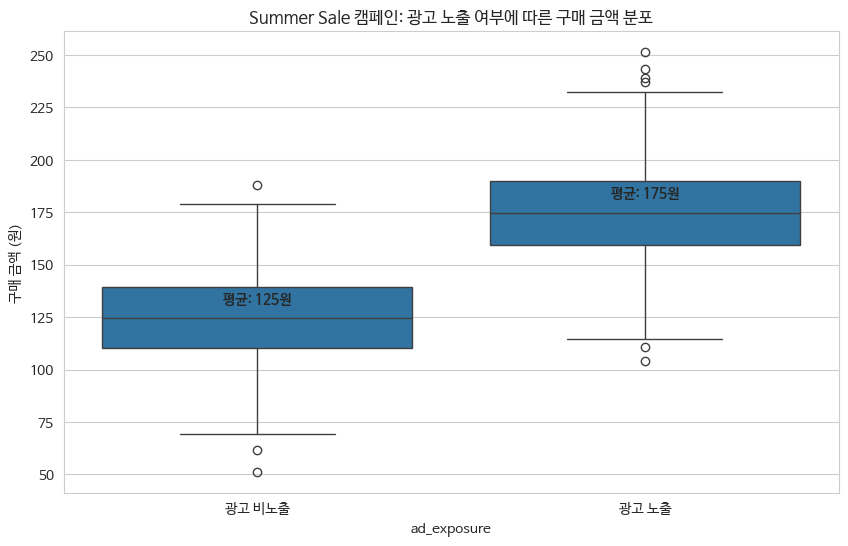

In [25]:
# [2-6]
plt.figure(figsize=(10, 6))
# Boxplot: 광고 노출 여부(ad_exposure)에 따른 구매 금액 분포
sns.boxplot(x='ad_exposure', y='purchase_amount', data=data_marketing)

plt.xticks([0, 1], ['광고 비노출', '광고 노출'])
plt.ylabel('구매 금액 (원)')
plt.title('Summer Sale 캠페인: 광고 노출 여부에 따른 구매 금액 분포')

# 평균값 표시
means = data_marketing.groupby('ad_exposure')['purchase_amount'].mean()
for i, mean_val in enumerate(means):
    plt.text(i, mean_val + 5, f'평균: {mean_val:.0f}원', ha='center', va='bottom', fontweight='bold')
plt.show()


In [28]:
# 📋 경영진 보고서: Summer Mega Sale 캠페인 효과 분석
# ==================================================
# 🎯 핵심 성과 지표
# • 광고 노출 그룹 평균 구매 금액: 175.32원
# • 광고 비노출 그룹 평균 구매 금액: 124.60원
# • 순수 광고 효과 (통제 후): 50.79원
# • 모델 설명력 (R²): 59.7%
# • 광고 ROI:
  # ✅ 광고는 개인당 구매 금액을 평균 50.79원 증가시킵니다.
  # 총 광고 노출: 614명
  # 예상 총 매출 증대: 31,186원
  # 광고 ROI: 55.9%
    # → 광고 투자 대비 양의 수익 창출

# 💡 전략적 권장사항:
# 1. **타겟팅 정교화:** 현재 ROI가 매우 낮으므로, 광고에 반응할 가능성이 높은 고객에게만 예산을 집중해야 합니다.
#    - **데이터 기반 타겟팅:** 구매 전환율이 높은 연령대, 소득 수준 또는 특정 관심사를 가진 고객 그룹을 식별하여 해당 그룹에 광고를 집중합니다.
#    - **리타겟팅 강화:** 기존에 우리 제품에 관심을 보였거나, 장바구니에 상품을 담았던 고객에게 광고를 다시 노출하여 구매를 유도합니다.
# 2. **캠페인 최적화 및 예산 재배분:**
#    - **A/B 테스트:** 9월 추석 캠페인에서는 다양한 광고 소재와 문구를 사용하여 A/B 테스트를 진행하고, 가장 효과적인 조합을 찾아냅니다.
#    - **예산 효율화:** ROI가 마이너스인 상황이므로, 전체 광고 예산을 축소하고, 효과가 검증된 채널과 전략에만 예산을 집중적으로 배분합니다.
# 3. **장기적 관점의 고객 가치 증대:**
#    - **첫 구매 유도:** 광고를 통해 첫 구매를 유도한 후, 고객 관계 관리(CRM)를 통해 재구매를 유도하여 장기적인 고객 가치(LTV)를 높이는 전략을 병행해야 합니다.

# ⚠️ 리스크 요소:
# - **관찰 데이터의 한계:** 이 분석은 무작위 통제 실험이 아니므로, 측정되지 않은 다른 요인(예: 개인의 쇼핑 성향, 브랜드 충성도)이 결과에 영향을 미쳤을 수 있습니다.
# - **장기 효과 미반영:** 광고가 브랜드 인지도 상승에 미치는 장기적인 효과는 이 분석에 포함되지 않았습니다. 단기적인 매출 증대 효과만으로 캠페인의 전체 가치를 평가해서는 안 됩니다.

# 📅 향후 액션 아이템:
# - **A/B 테스트 설계:** 9월 추석 캠페인을 위한 구체적인 A/B 테스트 계획(테스트 그룹, 기간, 측정 지표)을 수립합니다.
# - **추가 데이터 수집:** 고객의 구매 이력, 웹사이트 행동 데이터 등을 수집하여 다음 분석에서는 모델의 정확도를 높이고, 더 정교한 타겟팅을 가능하게 합니다.
# - **LTV 분석:** 신규 고객의 장기적인 가치를 분석하여, 광고를 통한 고객 획득 비용(CAC)과 비교하는 심층 분석을 진행합니다.

# 📋 미션 3: 고객 세분화 및 예측 모델링 보고서
    - 최근 1년간 고객 이탈률이 15%에서 23%로 급증
    - 월 매출이 50억원 감소


In [29]:
# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [35]:
np.random.seed(789)
n_users = 500
data_streaming = pd.DataFrame({
    'watch_hours': np.random.lognormal(np.log(10), 0.5, n_users).round(2),
    'content_diversity': np.random.uniform(1, 10, n_users).round(2),
    'subscription_duration': np.random.exponential(12, n_users).round(2),
    'satisfaction_score': np.random.normal(7, 1.5, n_users).round(2) })

churn_prob = 1 / (1 + np.exp((data_streaming['satisfaction_score'] - 5) +
                              0.1*data_streaming['watch_hours'] -
                              0.05*data_streaming['subscription_duration']))
data_streaming['churn'] = np.random.binomial(1, churn_prob)

# np.random.binomial(1, churn_prob)는 각 사용자에게 해당 churn_prob 확률로 1 (이탈) 또는 0 (이탈 안 함) 값을 무작위로 할당
# chrun 은 이탈률
    # 만족도를 5점으로 세팅
    # 1 / (1 + np.exp(x)): 시그모이드 함수의 형태

print("🛍️ 스트리밍 데이터 미리보기")
print(data_streaming.describe().round(2))
print(f"\n전체 이탈률: {data_streaming['churn'].mean()*100:.1f}%")


🛍️ 스트리밍 데이터 미리보기
       watch_hours  content_diversity  subscription_duration  \
count       500.00             500.00                 500.00   
mean         11.40               5.49                  12.22   
std           6.21               2.56                  12.30   
min           2.33               1.02                   0.04   
25%           7.25               3.30                   3.10   
50%          10.20               5.49                   8.00   
75%          14.00               7.70                  17.10   
max          61.74              10.00                  79.01   

       satisfaction_score   churn  
count              500.00  500.00  
mean                 7.03    0.15  
std                  1.54    0.36  
min                  2.73    0.00  
25%                  6.10    0.00  
50%                  7.02    0.00  
75%                  8.02    0.00  
max                 11.63    1.00  

전체 이탈률: 15.0%


In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# *fit_transform()**은 사이킷런(Scikit-learn)에서 데이터 전처리나 변환할 때 자주 등장하는 중요한 메서드

# 1. 표준화
features = ['watch_hours', 'content_diversity', 'subscription_duration', 'satisfaction_score']
X = data_streaming[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. PCA 분석 (2개 주성분으로 축소)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
  # components_ → 주성분 축(고유벡터)
  # explained_variance_ → 각 주성분의 분산값
  # explained_variance_ratio_ → 각 주성분이 전체 분산에서 차지하는 비율



print(f"PCA 설명된 분산 비율: {pca.explained_variance_ratio_.round(3)}")
print(f"누적 설명 분산: {pca.explained_variance_ratio_.sum()*100:.1f}%")
  # pca.explained_variance_ratio_ 는 pca 클래스에서 제공하는 속성(attribute)
      # PCA 설명된 분산 비율: [0.27  0.249]
      # 누적 설명 분산: 51.9%

# PCA 성분 해석
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['주성분1', '주성분2'],
    index=features
)
print("\n📊 PCA 성분 분석 (각 변수의 기여도)")
print(feature_importance.round(3))

 # [Result]

    #  PCA 설명된 분산 비율: [0.27  0.249]
    # 누적 설명 분산: 51.9%

    # 📊 PCA 성분 분석 (각 변수의 기여도)
    #                         주성분1   주성분2
    # watch_hours            0.523  0.245
    # content_diversity      0.500 -0.492
    # subscription_duration  0.337  0.797
    # satisfaction_score     0.602 -0.250

        #PCA1 해석 : 주성분 1은 **"사용자의 활동성과 만족도"**를 종합적으로 반영한 축
        #PCa2 해석 : 해석: 주성분 2는 **"구독 기간 중심 축"**

PCA 설명된 분산 비율: [0.27  0.249]
누적 설명 분산: 51.9%

📊 PCA 성분 분석 (각 변수의 기여도)
                        주성분1   주성분2
watch_hours            0.523  0.245
content_diversity      0.500 -0.492
subscription_duration  0.337  0.797
satisfaction_score     0.602 -0.250


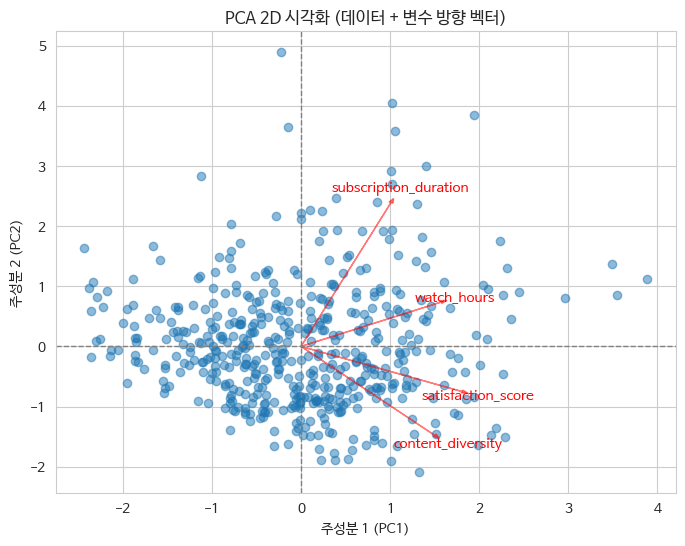

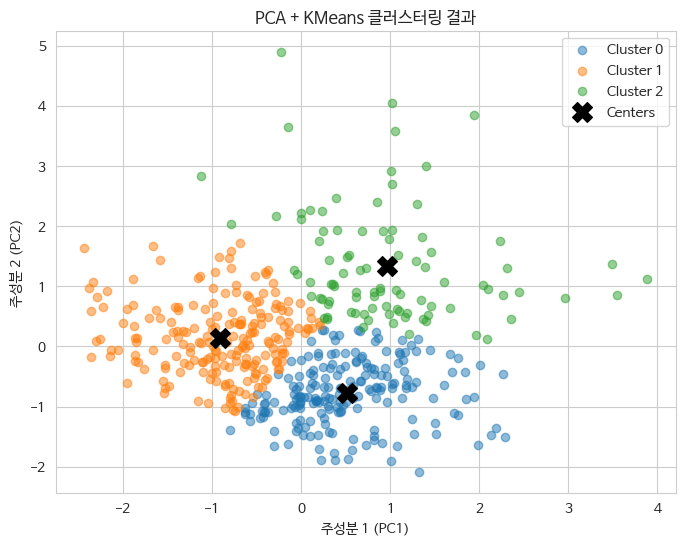

         watch_hours  content_diversity  subscription_duration  \
cluster                                                          
0          11.329444           7.258636               7.452828   
1           9.357190           3.809429               8.759095   
2          16.219783           5.494565              30.361848   

         satisfaction_score  
cluster                      
0                  7.810808  
1                  6.228952  
2                  7.181739  


In [50]:
# 이해를 위한 개별 확인 (by ChatGPT)

import matplotlib.pyplot as plt
import numpy as np

# PCA 결과 데이터프레임 (예시)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
# 데이터 산점도
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)

# 변수 로딩 벡터 (pca.components_는 shape=(n_components, n_features))
# components_[0] → PC1, components_[1] → PC2
for i, feature in enumerate(features):
    plt.arrow(0, 0,
              pca.components_[0, i]*3,  # 길이 조정용 *3
              pca.components_[1, i]*3,
              color='r', alpha=0.5, head_width=0.05)
    plt.text(pca.components_[0, i]*3*1.1,
             pca.components_[1, i]*3*1.1,
             feature, color='r', ha='center', va='center')

plt.xlabel("주성분 1 (PC1)")
plt.ylabel("주성분 2 (PC2)")
plt.title("PCA 2D 시각화 (데이터 + 변수 방향 벡터)")
plt.grid(True)
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.show()


from sklearn.cluster import KMeans

# 3개 군집 예시
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)  # PCA 결과 좌표 이용
pca_df['cluster'] = clusters

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for cluster_id in sorted(pca_df['cluster'].unique()):
    subset = pca_df[pca_df['cluster'] == cluster_id]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster_id}', alpha=0.5)

# 클러스터 중심
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], s=200, c='black', marker='X', label='Centers')

plt.xlabel('주성분 1 (PC1)')
plt.ylabel('주성분 2 (PC2)')
plt.title('PCA + KMeans 클러스터링 결과')
plt.legend()
plt.show()

# 군집별 평균 원래 변수 값
cluster_features = data_streaming.groupby(pca_df['cluster'])[features].mean()
print(cluster_features)


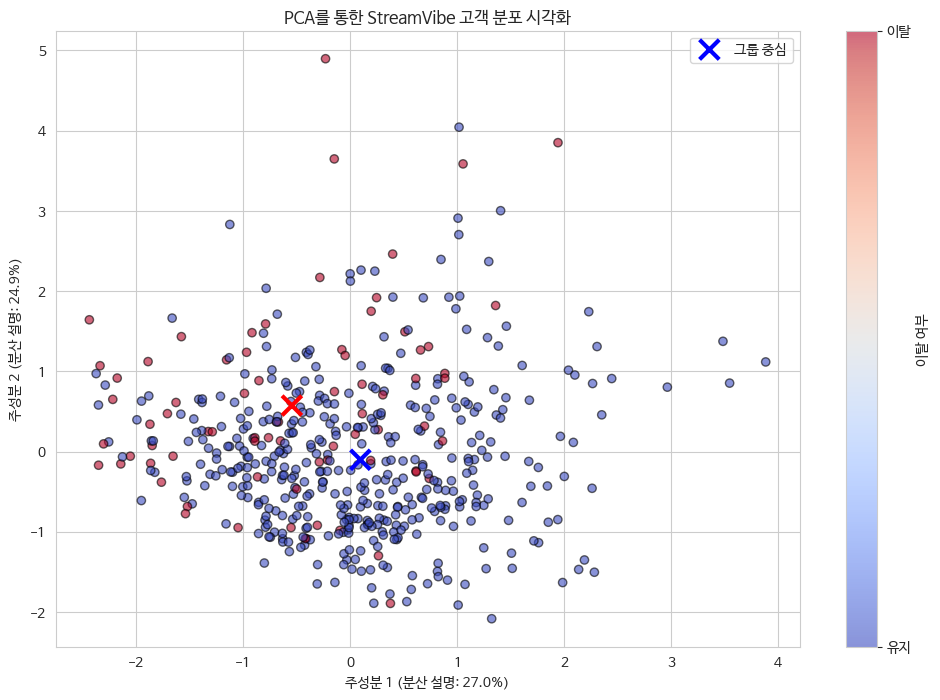

In [58]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

# PCA 산점도 (이탈 여부로 색상 구분)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=data_streaming['churn'], cmap='coolwarm', alpha=0.6, edgecolors='k')
       # c (color) : 무엇을 기준으로 색을 구분할지 지정 / cmap (colormap) : 색상을 어떤 팔레트(색상표)로 표현할지 선택




plt.xlabel(f'주성분 1 (분산 설명: {pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'주성분 2 (분산 설명: {pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA를 통한 StreamVibe 고객 분포 시각화')

# 컬러바 (0 = 유지, 1 = 이탈)
    # (colorbar)은 **앞서 설정한 c와 cmap에 대한 설명 축(범례 역할)**이라고 이해)
    # ticks : 차트 축(axis) 또는 컬러바(colorbar)에 표시되는 눈금(mark)
      # ticks 에 대한 레이블
          # [0,1] 인 이유 : c=data_streaming['churn'] → 이탈 여부 값(0=유지, 1=이탈)을 색깔 기준으로 사용했기 때문
cbar = plt.colorbar(scatter, label='이탈 여부')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['유지', '이탈'])



# 이탈/유지 고객 중심점 표시
churn_centers = data_streaming.groupby('churn')[features].mean()
    # churn 값(0=유지, 1=이탈)별로 **각 feature(시청시간, 콘텐츠 다양성, 구독 기간, 만족도)**의 평균을 계산
    # 즉, 각 그룹을 하나의 대표 벡터(평균점)로 요약
    # ↔ KMeans 중심점 을 활용해서 표시하는 방법도 有

churn_centers_scaled = scaler.transform(churn_centers)
churn_centers_pca = pca.transform(churn_centers_scaled)
plt.scatter(churn_centers_pca[:, 0], churn_centers_pca[:, 1],
            c=['blue', 'red'], s=200, marker='x', linewidths=3, label='그룹 중심')

plt.legend()
plt.show()


In [60]:
# [3-3] 고객 세분화_ k-평균 군집분석(k-means Clustering)
    # 동질적인 3개 세그먼트로 분류
    # 각 세그먼트의 특성과 이탈 위험도를 분석


kmeans = KMeans(n_clusters=3, random_state=789)
data_streaming['cluster'] = kmeans.fit_predict(X_pca)

cluster_summary = data_streaming.groupby('cluster')[features + ['churn']].mean()

print("📊 고객 세그먼트별 특징 분석")
print(cluster_summary.round(2))

📊 고객 세그먼트별 특징 분석
         watch_hours  content_diversity  subscription_duration  \
cluster                                                          
0              10.87               7.24                   7.30   
1               9.40               3.63                   9.07   
2              16.54               5.57                  28.81   

         satisfaction_score  churn  
cluster                             
0                      7.77   0.06  
1                      6.18   0.21  
2                      7.22   0.20  


In [72]:
# 각 클러스터의 비즈니스 해석
print("\n🎯 세그먼트 특성 해석:")
for cluster_id in range(3):  # 0~2 Cluster id Group
    cluster_data = cluster_summary.loc[cluster_id]
    churn_rate = cluster_data['churn'] * 100


    print(f"\n[세그먼트 {cluster_id}] - 이탈률: {churn_rate:.1f}%")
    print(f"  • 월 시청시간: {cluster_data['watch_hours']:.1f}시간")
    print(f"  • 콘텐츠 다양성: {cluster_data['content_diversity']:.1f}/10")
    print(f"  • 구독기간: {cluster_data['subscription_duration']:.1f}개월")
    print(f"  • 만족도: {cluster_data['satisfaction_score']:.1f}/10")

    # 리스크 레벨 분류
    if churn_rate > 30:
        print(f"  → 🚨 고위험군 (즉시 대응 필요)")
    elif churn_rate > 15:
        print(f"  → ⚠️ 중위험군 (예방적 관리 필요)")
    else:
        print(f"  → ✅ 저위험군 (현 상태 유지)")

# 세그먼트 크기
segment_sizes = data_streaming['cluster'].value_counts().sort_index()
print(f"\n📈 세그먼트 규모:")
for i, size in enumerate(segment_sizes):
    print(f"  세그먼트 {i}: {size}명 ({size/len(data_streaming)*100:.1f}%)")


# [cluster_data]

    # 2
    # watch_hours	16.544184
    # content_diversity	5.569184
    # subscription_duration	28.810306
    # satisfaction_score	7.215408
    # churn	0.204082


# [segment_sizes]
# cluster  count
  #  0	  204
  #  1  	198
  #  2	   98




🎯 세그먼트 특성 해석:

[세그먼트 0] - 이탈률: 6.4%
  • 월 시청시간: 10.9시간
  • 콘텐츠 다양성: 7.2/10
  • 구독기간: 7.3개월
  • 만족도: 7.8/10
  → ✅ 저위험군 (현 상태 유지)

[세그먼트 1] - 이탈률: 21.2%
  • 월 시청시간: 9.4시간
  • 콘텐츠 다양성: 3.6/10
  • 구독기간: 9.1개월
  • 만족도: 6.2/10
  → ⚠️ 중위험군 (예방적 관리 필요)

[세그먼트 2] - 이탈률: 20.4%
  • 월 시청시간: 16.5시간
  • 콘텐츠 다양성: 5.6/10
  • 구독기간: 28.8개월
  • 만족도: 7.2/10
  → ⚠️ 중위험군 (예방적 관리 필요)

📈 세그먼트 규모:
  세그먼트 0: 204명 (40.8%)
  세그먼트 1: 198명 (39.6%)
  세그먼트 2: 98명 (19.6%)


In [75]:
# [3-4] 이탈 예측 모델


X_logistic = X_scaled
y_logistic = data_streaming['churn']
logistic_model = LogisticRegression(random_state=789)
logistic_model.fit(X_logistic, y_logistic)

# 모델 학습 및 예측
y_pred_proba = logistic_model.predict_proba(X_logistic)[:, 1]  # [:, 1] → 두 번째 열(클래스 1, 즉 이탈일 확률)만 추출
y_pred = logistic_model.predict(X_logistic)  # predict() → 확률이 0.5 이상이면 1, 아니면 0으로 자동 분류 (디폴트 Threshold=0.5)

accuracy = (y_pred == y_logistic).mean()
print(f"이탈 예측 모델 정확도: {accuracy:.3f} ({accuracy*100:.1f}%)")  # 정확도(Accuracy): 맞게 예측한 비율

# 변수별 중요도 분석
feature_importance = pd.DataFrame({
    '변수': features,
    '계수': logistic_model.coef_[0],
    '중요도': np.abs(logistic_model.coef_[0])
}).sort_values('중요도', ascending=False)

print("\n📊 이탈 예측 주요 변수")
print(feature_importance.round(3))

# 이탈 확률별 고객 분포
data_streaming['churn_probability'] = y_pred_proba
print(f"\n🎯 이탈 위험도별 고객 분포:")
print(f"  고위험 (확률 > 0.7): {(y_pred_proba > 0.7).sum()}명")
print(f"  중위험 (0.3 < 확률 ≤ 0.7): {((y_pred_proba > 0.3) & (y_pred_proba <= 0.7)).sum()}명")
print(f"  저위험 (확률 ≤ 0.3): {(y_pred_proba <= 0.3).sum()}명")


# 이탈 예측 모델 정확도: 0.868 (86.8%)

# 📊 이탈 예측 주요 변수
#                       변수     계수    중요도
# 3     satisfaction_score -1.367  1.367
# 2  subscription_duration  0.600  0.600
# 0            watch_hours -0.441  0.441
# 1      content_diversity  0.028  0.028

# 🎯 이탈 위험도별 고객 분포:
#   고위험 (확률 > 0.7): 11명
#   중위험 (0.3 < 확률 ≤ 0.7): 69명
#   저위험 (확률 ≤ 0.3): 420명

이탈 예측 모델 정확도: 0.868 (86.8%)

📊 이탈 예측 주요 변수
                      변수     계수    중요도
3     satisfaction_score -1.367  1.367
2  subscription_duration  0.600  0.600
0            watch_hours -0.441  0.441
1      content_diversity  0.028  0.028

🎯 이탈 위험도별 고객 분포:
  고위험 (확률 > 0.7): 11명
  중위험 (0.3 < 확률 ≤ 0.7): 69명
  저위험 (확률 ≤ 0.3): 420명


In [77]:
# [3-5] 혼동 행렬 계산
cm = confusion_matrix(y_logistic, y_pred)
print(cm)

tn, fp, fn, tp = cm.ravel()

print("📋 이탈 예측 모델 성능 분석")
print(f"정확히 예측한 유지 고객 (True Negative): {tn}명")
print(f"이탈로 잘못 예측한 유지 고객 (False Positive): {fp}명")
print(f"유지로 잘못 예측한 이탈 고객 (False Negative): {fn}명")
print(f"정확히 예측한 이탈 고객 (True Positive): {tp}명")

# 비즈니스 메트릭 계산
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n🎯 비즈니스 성과 지표:")
print(f"정밀도 (Precision): {precision:.3f} - 이탈 예측 중 실제 이탈 비율")
print(f"재현율 (Recall): {recall:.3f} - 실제 이탈 고객 중 예측 성공 비율")
print(f"F1-Score: {f1_score:.3f} - 종합 성능 지표")

# 비즈니스 손실 분석
retention_cost_per_customer = 50000  # 고객 유지 비용 (쿠폰, 할인 등)
lost_revenue_per_churn = 200000     # 이탈 고객당 매출 손실

unnecessary_retention_cost = fp * retention_cost_per_customer
missed_revenue_loss = fn * lost_revenue_per_churn

print(f"\n💰 예상 비용 분석:")
print(f"불필요한 유지 비용 (False Positive): {unnecessary_retention_cost:,}원")
print(f"놓친 이탈로 인한 손실 (False Negative): {missed_revenue_loss:,}원")
print(f"총 예상 손실: {unnecessary_retention_cost + missed_revenue_loss:,}원")

# [Result]
    # [[413  12]
    #  [ 54  21]]
    # 📋 이탈 예측 모델 성능 분석
    # 정확히 예측한 유지 고객 (True Negative): 413명
    # 이탈로 잘못 예측한 유지 고객 (False Positive): 12명
    # 유지로 잘못 예측한 이탈 고객 (False Negative): 54명
    # 정확히 예측한 이탈 고객 (True Positive): 21명

    # 🎯 비즈니스 성과 지표:
    # 정밀도 (Precision): 0.636 - 이탈 예측 중 실제 이탈 비율
    # 재현율 (Recall): 0.280 - 실제 이탈 고객 중 예측 성공 비율
    # F1-Score: 0.389 - 종합 성능 지표 (F1-score = Precision과 Recall의 균형 지표. 즉, Precision과 Recall의 조화 평균(Harmonic Mean))

    # 💰 예상 비용 분석:
    # 불필요한 유지 비용 (False Positive): 600,000원
    # 놓친 이탈로 인한 손실 (False Negative): 10,800,000원
    # 총 예상 손실: 11,400,000원

[[413  12]
 [ 54  21]]
📋 이탈 예측 모델 성능 분석
정확히 예측한 유지 고객 (True Negative): 413명
이탈로 잘못 예측한 유지 고객 (False Positive): 12명
유지로 잘못 예측한 이탈 고객 (False Negative): 54명
정확히 예측한 이탈 고객 (True Positive): 21명

🎯 비즈니스 성과 지표:
정밀도 (Precision): 0.636 - 이탈 예측 중 실제 이탈 비율
재현율 (Recall): 0.280 - 실제 이탈 고객 중 예측 성공 비율
F1-Score: 0.389 - 종합 성능 지표

💰 예상 비용 분석:
불필요한 유지 비용 (False Positive): 600,000원
놓친 이탈로 인한 손실 (False Negative): 10,800,000원
총 예상 손실: 11,400,000원


FPR: [0.         0.         0.         0.00235294 0.00235294 0.00470588
 0.00470588 0.00705882 0.00705882 0.01176471 0.01176471 0.01647059
 0.01647059 0.02117647 0.02117647 0.02352941 0.02352941 0.02588235
 0.02588235 0.03058824 0.03058824 0.03529412 0.03529412 0.04470588
 0.04470588 0.05176471 0.05176471 0.05411765 0.05411765 0.05647059
 0.05647059 0.05882353 0.05882353 0.06823529 0.06823529 0.07294118
 0.07294118 0.07764706 0.07764706 0.08       0.08       0.10352941
 0.10352941 0.11058824 0.11058824 0.11764706 0.11764706 0.12705882
 0.12705882 0.12941176 0.12941176 0.13176471 0.13176471 0.13882353
 0.13882353 0.14588235 0.14588235 0.17176471 0.17176471 0.19294118
 0.19294118 0.19529412 0.19529412 0.2        0.2        0.20235294
 0.20235294 0.22588235 0.22588235 0.24941176 0.24941176 0.25176471
 0.25176471 0.26352941 0.26352941 0.27764706 0.27764706 0.29411765
 0.29411765 0.31294118 0.31294118 0.31529412 0.31529412 0.41411765
 0.41411765 0.42588235 0.42588235 0.43294118 0.43294118 0

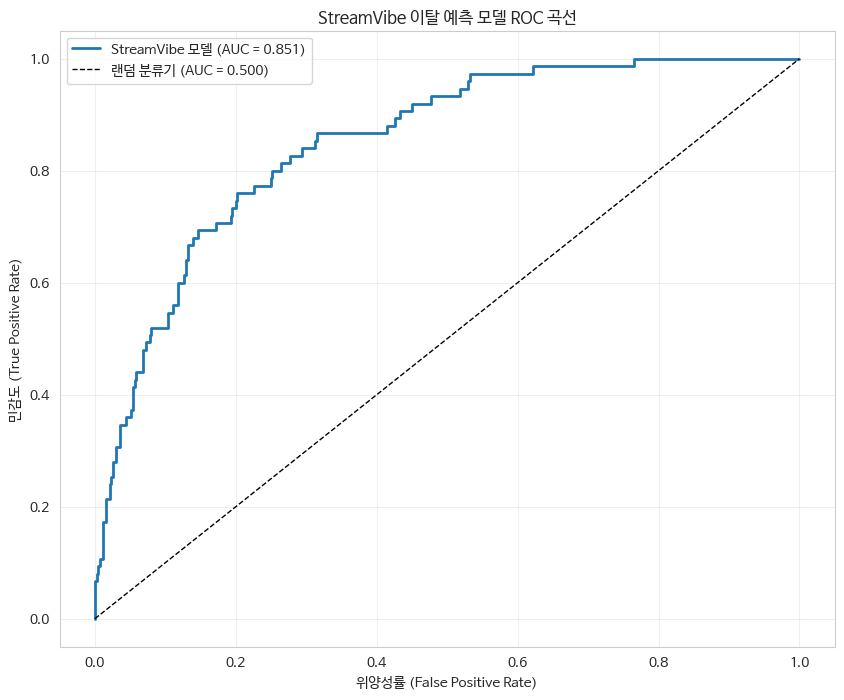

🎯 최적 예측 임계값: 0.165
   이 임계값에서 민감도: 0.760, 특이도: 0.798


In [78]:
# [3-6]
from sklearn.metrics import roc_curve, roc_auc_score

# ROC 곡선 계산 (y_true = 실제값, y_score = 이탈 확률)
    # ROC (Receiver Operating Characteristic) 곡선
    # 분류 모델이 **Threshold(임계값)**를 바꿔가며 얼마나 Positive를 구분하는지 보여주는 그래프
        # Threshold를 0~1로 변화시키면서 FPR과 TPR 값을 계산
        # ROC 곡선은 threshold를 쭉 바꿔가며 계산한 결과



fpr, tpr, thresholds = roc_curve(y_logistic, y_pred_proba)
    # x축(ROC 곡선)
    # y축(ROC 곡선)
      # **roc_curve()**는 0.0 ~ 1.0 범위를 모두 고려해서 여러 threshold 값을 자동 생성

# AUC 계산
roc_auc = roc_auc_score(y_logistic, y_pred_proba)

print("FPR:", fpr)
print("TPR:", tpr)
print("Thresholds:", thresholds)
print("AUC:", roc_auc)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'StreamVibe 모델 (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='랜덤 분류기 (AUC = 0.500)')
plt.xlabel('위양성률 (False Positive Rate)')
plt.ylabel('민감도 (True Positive Rate)')
plt.title('StreamVibe 이탈 예측 모델 ROC 곡선')
plt.legend()
plt.grid(True, alpha=0.3)

# AUC 성능 해석
if roc_auc > 0.9:
    performance_level = "탁월함 (업계 최고 수준)"
elif roc_auc > 0.8:
    performance_level = "우수함 (상용화 가능 수준)"
elif roc_auc > 0.7:
    performance_level = "양호함 (개선 여지 있음)"
else:
    performance_level = "부족함 (추가 개선 필요)"

print(f"📊 AUC 성능 평가: {roc_auc:.3f} → {performance_level}")
plt.show()

# 최적 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"🎯 최적 예측 임계값: {optimal_threshold:.3f}")
print(f"   이 임계값에서 민감도: {tpr[optimal_idx]:.3f}, 특이도: {1-fpr[optimal_idx]:.3f}")


  # 임계값을 0.165로 설정하면 이탈 고객 76%를 잡고, 유지 고객 80%를 보호함
  # 균형 잡힌 threshold로 평가 가능 (특히 비즈니스에서 이탈 예측용으로 나쁘지 않은 수준)

In [79]:
# 📋 경영진 보고서: SmartLearn 프로그램 효과 검증
# ==================================================
# 🎯 핵심 결과
# • 대조군 수학 점수: 64.93 ± 0.79
# • SmartLearn 수학 점수: 70.47 ± 0.92
# • 점수 향상: 5.54점 (약 8.53% 향상)
# • 효과크기 (Cohen's d): 58.224 → 큰 효과크기 (학부모가 명확히 체감할 수 있는 수준)
# • p-value: 0.0000 (p < 0.0001, 통계적으로 매우 유의미)
# • 베이즈 인수: 1934.97 → 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)

# 💡 비즈니스 결론 및 권장사항:
# **결론:**
# SmartLearn 프로그램은 학생들의 수학 점수를 통계적으로 유의미하게 향상시키는 효과가 있으며, 그 효과의 크기는 교육적으로 매우 의미 있는 수준입니다. 베이즈 분석 결과 또한 프로그램의 효과를 강력하게 지지하므로, SmartLearn의 상용화는 긍정적으로 검토할 수 있습니다.

# **권장사항:**
# 1. **상용화 및 마케팅:**
#    - **핵심 메시지:** "평균 8.5% 점수 향상", "과학적으로 검증된 학습 효과" 등 구체적인 데이터를 활용하여 마케팅 메시지를 구성합니다.
#    - **타겟 고객:** 성적 향상에 대한 요구가 높은 학생 및 학부모를 핵심 타겟으로 설정하고, 체험 프로그램 등을 통해 효과를 직접 경험하게 하는 전략을 사용합니다.
# 2. **투자 방향:**
#    - **서비스 안정화:** 상용화를 위해 서버, 고객 지원 시스템 등 인프라에 대한 투자를 확대합니다.
#    - **콘텐츠 확장:** 수학 외 다른 과목으로 프로그램을 확장하는 것을 검토하여 시장을 확대합니다.
# 3. **교육부 및 공교육 연계:**
#    - **효과성 입증 자료 제출:** 분석 보고서를 교육부에 제출하여 프로그램의 우수성을 알리고, 공교육 현장에서의 활용 가능성을 타진합니다.
#    - **방과 후 학교 프로그램 제휴:** 학교와의 제휴를 통해 방과 후 프로그램으로 SmartLearn을 도입하는 방안을 추진합니다.

# ⚠️ 리스크 및 제한사항:
# - **일반화의 한계:** 이번 연구는 특정 기간, 특정 학생들을 대상으로 진행되었으므로, 다른 환경의 학생들에게도 동일한 효과가 나타날 것이라고 단정하기는 어렵습니다.
# - **장기적 효과:** 단기적인 성적 향상 효과는 확인되었으나, 장기적인 학습 태도 변화나 자기주도학습 능력 향상 등 다른 교육적 효과에 대한 추가적인 검증이 필요합니다.
# - **비용 대비 효과:** 프로그램의 가격을 고려했을 때, 학부모가 느끼는 비용 대비 효과가 어느 정도일지에 대한 시장 조사가 필요합니다.